In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

import scipy.linalg as spl

# Function for testing positive definiteness
def is_pos_def(A):
    if np.allclose(A, A.conj().T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

comment = "Fit to covariance in sim"
nb_name = "nb_midpath_dynamo_covmod_sim"

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)
core.generate_map(target_var_factor = 1)

core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

In [3]:
core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


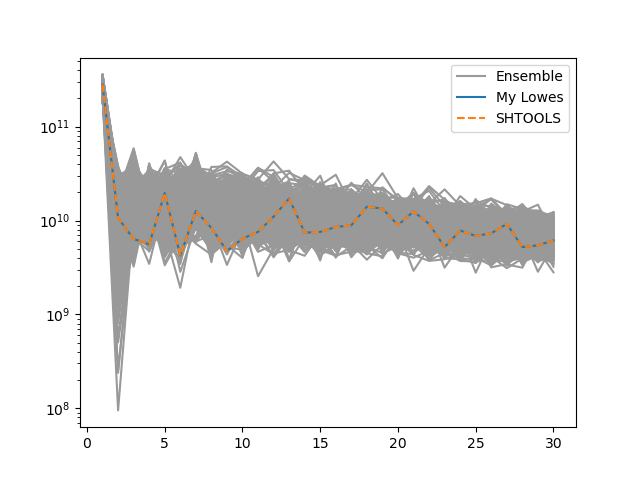

In [7]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

# g ensemble and parameters
g_core_ens = np.genfromtxt("mikkel_tools/models_shc/gnm_midpath.dat").T*10**9
g_core_ens = g_core_ens[:mt_util.shc_vec_len(shc_g),:]

a = core.a
c = core.r_cmb
n_max = shc_g

g_cut = g_core_ens[:n_max*(2+n_max),200:] # Truncate g
R = mt_util.lowe_shspec(n_max,c,a,g_cut)

# One spectra for comparison to SHTOOLS
g_cut_one = g_core_ens[:,core.ens_idx][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

# SHTOOLS
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))
p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

# Spectra
plt.figure()
for i in np.arange(R.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6),label="Ensemble")
    else:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one,label="My Lowes")
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed", label="SHTOOLS")
plt.legend()
plt.show()

# New tapered cov

[]


<IPython.core.display.Javascript object>


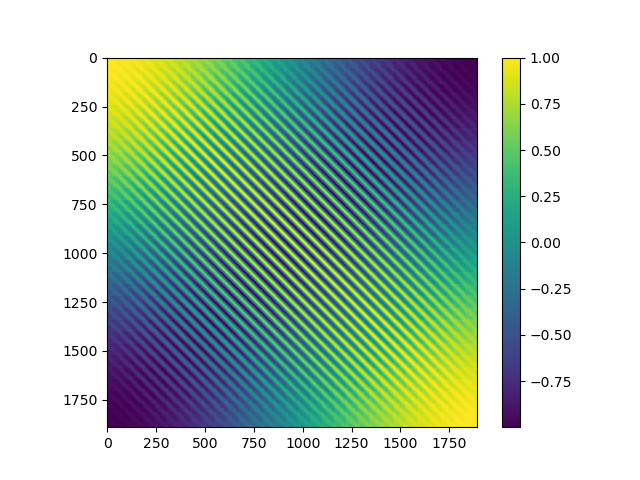

In [8]:
c_angdist = np.cos(mt_util.haversine(1, core.grid_phi.reshape(1,-1), 90-core.grid_theta.reshape(1,-1), 
                              core.grid_phi.reshape(-1,1), 90-core.grid_theta.reshape(-1,1)))

print(c_angdist[c_angdist>1])

plt.figure()
plt.imshow(c_angdist)
plt.colorbar()
plt.show()

In [9]:
tap_to = 501 # One extra for overlap between R_add and R
n_tap = n_max + tap_to - 1 # And one less as a result

tap_cos = np.cos(np.linspace(0,np.pi,20))+1
tap_cos_norm = ((tap_cos - np.min(tap_cos))/(np.max(tap_cos)-np.min(tap_cos))).reshape(-1,1)

# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_tap+1)+1)/(2*np.arange(1,n_tap+1)+1)

# Pn
Pn = []
for cmu in np.ravel(c_angdist):
    Pn.append(pyshtools.legendre.PlSchmidt(n_tap,cmu)[1:].reshape(-1,1))

Pn = np.array(Pn).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

<IPython.core.display.Javascript object>


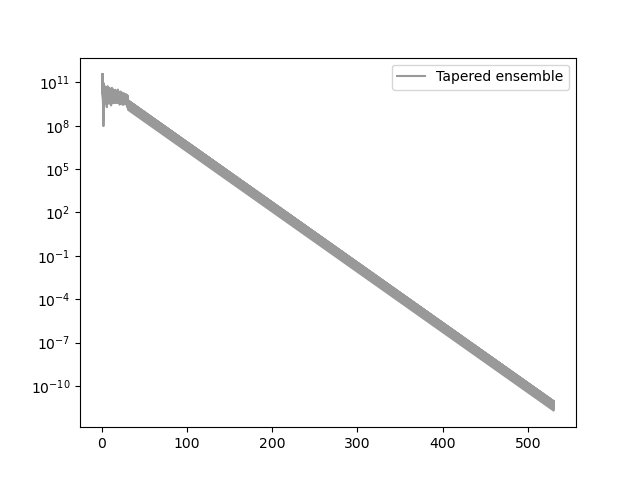

PD:  True


In [14]:
lin_exp = np.linspace(0,24,tap_to)
tap_exp = (0.5*np.exp(-200*lin_exp) + 0.5*np.exp(-2*lin_exp)).reshape(-1,1)


R_add = R[-1,:]*tap_exp
R_tap = np.vstack((R,R_add[1:,:]))

# Spectra
plt.figure()
for i in np.arange(R_tap.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
        #plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
    else:
        plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
        #plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
plt.legend()
plt.show()

C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

C_Br_model = C_Br[:,:,core.ens_idx]

PD = is_pos_def(C_Br_model)
print("PD: ", PD)

<IPython.core.display.Javascript object>


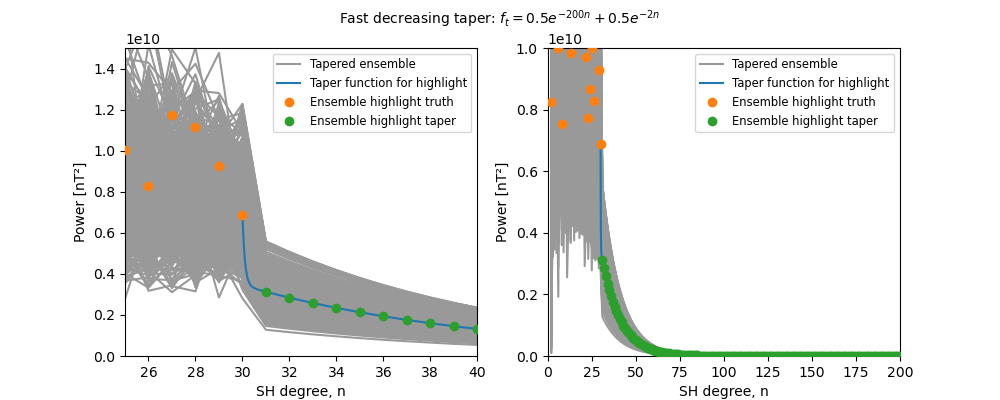

In [18]:
lin_exp = np.linspace(0,24,10000)
lin_deg = np.linspace(1,501,10000)
tap_exp = (0.5*np.exp(-200*lin_exp) + 0.5*np.exp(-2*lin_exp)).reshape(-1,1)
R_show = R[-1,:]*tap_exp

# Spectra
#fig, ax = plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for i in np.arange(R_tap.shape[1]):
    if i == 0:
        axes[0].plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
        axes[0].plot(lin_deg+29,R_show[:,core.ens_idx],zorder = 10, label ="Taper function for highlight")
        axes[0].plot(np.arange(1,n_tap+1)[:30],R_tap[:30,core.ens_idx],"o",zorder = 11, label = "Ensemble highlight truth")
        axes[0].plot(np.arange(1,n_tap+1)[30:],R_tap[30:,core.ens_idx],"o",zorder = 11, label = "Ensemble highlight taper")
        
        axes[1].plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
        axes[1].plot(lin_deg+29,R_show[:,core.ens_idx],zorder = 10, label ="Taper function for highlight")
        axes[1].plot(np.arange(1,n_tap+1)[:30],R_tap[:30,core.ens_idx],"o",zorder = 11, label = "Ensemble highlight truth")
        axes[1].plot(np.arange(1,n_tap+1)[30:],R_tap[30:,core.ens_idx],"o",zorder = 11, label = "Ensemble highlight taper")

        #axes[1].semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
    else:
        axes[0].plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
        axes[1].plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
        #axes[1].semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))

axes[0].set_xlim(25,40)
axes[0].set_ylim(0,1.5*10**10)
axes[1].set_xlim(0,200)
axes[1].set_ylim(0, 10**10)
axes[0].legend(fontsize="small")
axes[1].legend(fontsize="small")
axes[0].set_ylabel("Power [nT²]")
axes[0].set_xlabel("SH degree, n")
axes[1].set_ylabel("Power [nT²]")
axes[1].set_xlabel("SH degree, n")
fig.suptitle('Fast decreasing taper: $f_t = 0.5e^{-200n} + 0.5e^{-2n}$', fontsize=10)
plt.show()

In [19]:
C_Br_model = np.mean(C_Br,axis=2)

<IPython.core.display.Javascript object>


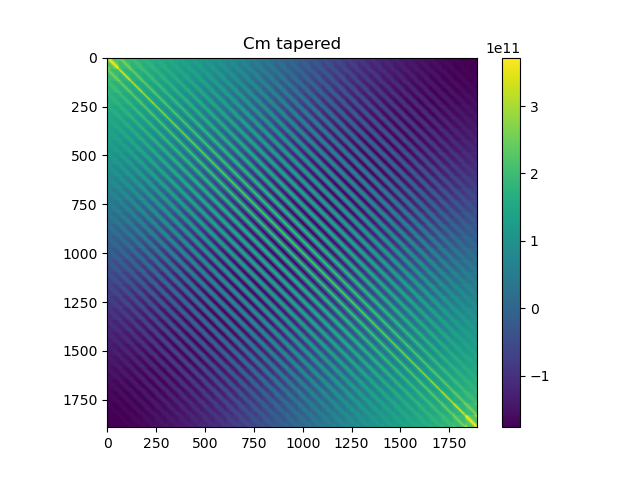

C_Br_model is pos def: True
All eigenvalues > 0: True
Number of negative eigenvalues: 0 / 1891


<IPython.core.display.Javascript object>


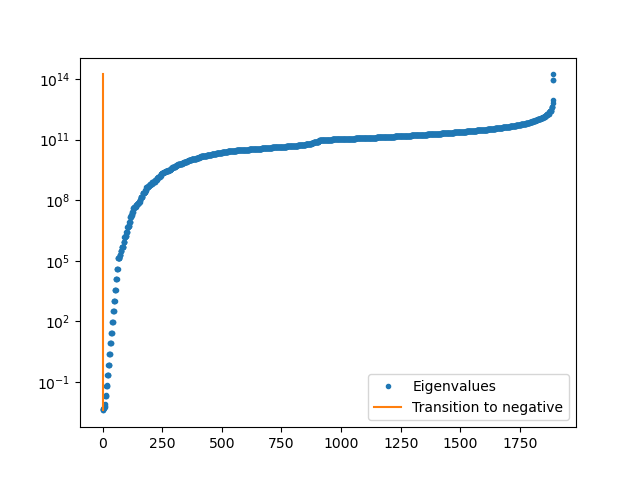

In [20]:
plt.figure()
plt.title("Cm tapered")
plt.imshow(C_Br_model)
plt.colorbar()
plt.show()

# Positive definite covariance?
core_eigval = spl.eigh(C_Br_model, eigvals_only=True)
N_neg_eigval = len(core_eigval[core_eigval<=0])
print("C_Br_model is pos def:", is_pos_def(C_Br_model))
print("All eigenvalues > 0:", np.all(core_eigval>=0))
print("Number of negative eigenvalues:",N_neg_eigval,"/",len(core_eigval))

plt.figure()
plt.semilogy(np.arange(0,len(core_eigval)),core_eigval,'.',label="Eigenvalues")
plt.semilogy(np.ones((100,))*N_neg_eigval,np.linspace(core_eigval[N_neg_eigval],core_eigval[-1],100),label="Transition to negative")
plt.legend()
plt.show()

# Synthetic sat

In [21]:
C_e_const = 2.0

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth

In [22]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations

In [23]:
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = C_Br_model)

# SDSSIM

 |----------| 6.7%   realization nr. 0. Counter: 126/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.157 minutes 
Total elapsed time: 1.157 minutes 
Variance: 426260409691.741
Mean: -30775.642
Max: 3138970.475
Min: -2580372.788
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.033 minutes 
Total elapsed time: 2.190 minutes 
Variance: 471188605145.123
Mean: -48227.872
Max: 2942697.649
Min: -3065094.815
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.168 minutes 
Total elapsed time: 3.358 minutes 
Variance: 220717844958.406
Mean: -11050.020
Max: 3124347.561
Min: -4853942.793
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.103 minutes 
Total elapsed time: 4.461 minutes 
Variance: 226574156907.706
Mean: 42051.788
Max: 4326820.342
Min: -1575596.762
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realizatio

 |----------| 7.5%   realization nr. 34. Counter: 141/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 34. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.064 minutes 
Total elapsed time: 37.000 minutes 
Variance: 252748436974.198
Mean: -10045.041
Max: 1933839.315
Min: -1569776.914
Run nr.: 35

 |OOOOOOOOOO| 100.0%   realization nr. 35. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 59.813 seconds 
Total elapsed time: 37.997 minutes 
Variance: 283472961523.062
Mean: 18741.880
Max: 1789175.752
Min: -3382368.428
Run nr.: 36

 |OOOOOOOOOO| 100.0%   realization nr. 36. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.195 minutes 
Total elapsed time: 39.192 minutes 
Variance: 481048614198.360
Mean: -1729.319
Max: 4867032.066
Min: -4162310.247
Run nr.: 37

 |OOOOOOOOOO| 100.0%   realization nr. 37. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.103 minutes 
Total elapsed time: 40.295 minutes 
Variance: 244152273259.222
Mean: 10494.365
Max: 3224353.208
Min: -2090108.115
Run nr.: 38

 |OOOOOOOOOO| 100.0%  

 |----------| 7.5%   realization nr. 68. Counter: 142/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 68. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.025 minutes 
Total elapsed time: 1.215 hours 
Variance: 351529540605.263
Mean: -20167.483
Max: 4208937.639
Min: -2375687.905
Run nr.: 69

 |OOOOOOOOOO| 100.0%   realization nr. 69. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.142 minutes 
Total elapsed time: 1.235 hours 
Variance: 304307484579.533
Mean: -6149.574
Max: 1531353.550
Min: -4832983.013
Run nr.: 70

 |OOOOOOOOOO| 100.0%   realization nr. 70. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.144 minutes 
Total elapsed time: 1.254 hours 
Variance: 208907586293.537
Mean: 1763.684
Max: 1648834.501
Min: -2331880.177
Run nr.: 71

 |OOOOOOOOOO| 100.0%   realization nr. 71. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.157 minutes 
Total elapsed time: 1.273 hours 
Variance: 223696768919.881
Mean: -14141.657
Max: 2937514.695
Min: -4895380.164
Run nr.: 72

 |OOOOOOOOOO| 100.0%   realization 

 |----------| 7.5%   realization nr. 102. Counter: 142/1891, Running error magnitude: 5.6

 |O---------| 12.7%   realization nr. 102. Counter: 240/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 102. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.008 minutes 
Total elapsed time: 1.815 hours 
Variance: 218492357189.251
Mean: -55400.112
Max: 4846073.439
Min: -1631283.516
Run nr.: 103

 |OOOOOOOOOO| 100.0%   realization nr. 103. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 59.828 seconds 
Total elapsed time: 1.832 hours 
Variance: 237312130358.798
Mean: 27093.803
Max: 1455477.137
Min: -1507557.980
Run nr.: 104

 |OOOOOOOOOO| 100.0%   realization nr. 104. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 59.476 seconds 
Total elapsed time: 1.848 hours 
Variance: 227988931308.920
Mean: -20775.973
Max: 3513708.449
Min: -1484175.269
Run nr.: 105

 |OOOOOOOOOO| 100.0%   realization nr. 105. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.021 minutes 
Total elapsed time: 1.865 hours 
Variance: 257780429358.197
Mean: 2278.453
Max: 2924668.501
Min: -1794107.589
Run nr.: 106

 |OOOOOOOOOO| 100.0%   re

 |----------| 7.4%   realization nr. 136. Counter: 139/1891, Running error magnitude: 5.4

 |O---------| 12.3%   realization nr. 136. Counter: 232/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 136. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.045 minutes 
Total elapsed time: 2.412 hours 
Variance: 252904893341.684
Mean: 10437.983
Max: 2555693.492
Min: -1855287.678
Run nr.: 137

 |OOOOOOOOOO| 100.0%   realization nr. 137. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.071 minutes 
Total elapsed time: 2.429 hours 
Variance: 363423404201.350
Mean: 7123.795
Max: 3194764.140
Min: -3438520.201
Run nr.: 138

 |OOOOOOOOOO| 100.0%   realization nr. 138. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.014 minutes 
Total elapsed time: 2.446 hours 
Variance: 208766448618.709
Mean: 22296.475
Max: 1796199.766
Min: -1498980.832
Run nr.: 139

 |OOOOOOOOOO| 100.0%   realization nr. 139. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 59.516 seconds 
Total elapsed time: 2.463 hours 
Variance: 440970903393.802
Mean: -37849.652
Max: 4014942.779
Min: -2559313.764
Run nr.: 140

 |OOOOOOOOOO| 100.0%   real

 |----------| 7.5%   realization nr. 170. Counter: 141/1891, Running error magnitude: 5.4

 |OOOOOOOOOO| 100.0%   realization nr. 170. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.139 minutes 
Total elapsed time: 3.013 hours 
Variance: 474964704594.024
Mean: -28417.474
Max: 3170689.304
Min: -4221772.385
Run nr.: 171

 |OOOOOOOOOO| 100.0%   realization nr. 171. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.104 minutes 
Total elapsed time: 3.032 hours 
Variance: 458886503987.757
Mean: -8016.385
Max: 4757881.463
Min: -4558616.746
Run nr.: 172

 |OOOOOOOOOO| 100.0%   realization nr. 172. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.082 minutes 
Total elapsed time: 3.050 hours 
Variance: 254797146414.280
Mean: 23461.287
Max: 2771220.192
Min: -2597912.321
Run nr.: 173

 |OOOOOOOOOO| 100.0%   realization nr. 173. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.011 minutes 
Total elapsed time: 3.067 hours 
Variance: 258490695392.229
Mean: -19050.940
Max: 4742517.831
Min: -4359456.877
Run nr.: 174

 |OOOOOOOOOO| 100.0%   rea

 |----------| 7.7%   realization nr. 204. Counter: 146/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 204. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.008 minutes 
Total elapsed time: 3.593 hours 
Variance: 346577976086.805
Mean: -6782.004
Max: 4821234.355
Min: -1607602.664
Run nr.: 205

 |OOOOOOOOOO| 100.0%   realization nr. 205. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.005 minutes 
Total elapsed time: 3.610 hours 
Variance: 884530940837.274
Mean: -10460.824
Max: 4474490.675
Min: -3964049.967
Run nr.: 206

 |OOOOOOOOOO| 100.0%   realization nr. 206. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.157 minutes 
Total elapsed time: 3.629 hours 
Variance: 287019954630.077
Mean: 17780.121
Max: 2834632.016
Min: -3330708.585
Run nr.: 207

 |OOOOOOOOOO| 100.0%   realization nr. 207. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.176 minutes 
Total elapsed time: 3.649 hours 
Variance: 234024498288.522
Mean: -26214.349
Max: 1905102.525
Min: -4284349.415
Run nr.: 208

 |OOOOOOOOOO| 100.0%   rea

 |----------| 7.0%   realization nr. 238. Counter: 132/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 238. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.122 minutes 
Total elapsed time: 4.201 hours 
Variance: 212170123769.755
Mean: 18533.436
Max: 4881506.313
Min: -1588591.285
Run nr.: 239

 |OOOOOOOOOO| 100.0%   realization nr. 239. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.019 minutes 
Total elapsed time: 4.218 hours 
Variance: 342020840445.863
Mean: 20646.810
Max: 3902518.847
Min: -2983167.712
Run nr.: 240

 |OOOOOOOOOO| 100.0%   realization nr. 240. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.017 minutes 
Total elapsed time: 4.235 hours 
Variance: 236917480402.502
Mean: -22292.482
Max: 2330614.043
Min: -2511735.458
Run nr.: 241

 |OOOOOOOOOO| 100.0%   realization nr. 241. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 59.834 seconds 
Total elapsed time: 4.251 hours 
Variance: 229517730580.055
Mean: -39.037
Max: 3285849.267
Min: -1573500.003
Run nr.: 242

 |OOOOOOOOOO| 100.0%   reali

 |----------| 6.4%   realization nr. 272. Counter: 121/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 272. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.125 minutes 
Total elapsed time: 4.808 hours 
Variance: 274161951740.376
Mean: 32065.672
Max: 1477336.710
Min: -4785450.380
Run nr.: 273

 |OOOOOOOOOO| 100.0%   realization nr. 273. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.181 minutes 
Total elapsed time: 4.828 hours 
Variance: 256940831757.075
Mean: -17689.491
Max: 2778554.139
Min: -3129125.702
Run nr.: 274

 |OOOOOOOOOO| 100.0%   realization nr. 274. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.135 minutes 
Total elapsed time: 4.847 hours 
Variance: 491210268493.096
Mean: 25092.849
Max: 3741227.503
Min: -3913403.250
Run nr.: 275

 |OOOOOOOOOO| 100.0%   realization nr. 275. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.074 minutes 
Total elapsed time: 4.865 hours 
Variance: 291555496805.356
Mean: -37664.974
Max: 3699617.206
Min: -2715132.195
Run nr.: 276

 |OOOOOOOOOO| 100.0%   rea

 |----------| 7.0%   realization nr. 306. Counter: 133/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 306. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.174 minutes 
Total elapsed time: 5.423 hours 
Variance: 289357560874.319
Mean: 8325.118
Max: 2386794.200
Min: -1586526.360
Run nr.: 307

 |OOOOOOOOOO| 100.0%   realization nr. 307. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.102 minutes 
Total elapsed time: 5.441 hours 
Variance: 176086913435.654
Mean: -780.087
Max: 1527243.887
Min: -1419187.042
Run nr.: 308

 |OOOOOOOOOO| 100.0%   realization nr. 308. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.246 minutes 
Total elapsed time: 5.462 hours 
Variance: 233152923769.012
Mean: -20299.750
Max: 2523672.992
Min: -1497062.689
Run nr.: 309

 |OOOOOOOOOO| 100.0%   realization nr. 309. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.160 minutes 
Total elapsed time: 5.481 hours 
Variance: 280452363048.764
Mean: 53501.425
Max: 4811069.075
Min: -4870436.605
Run nr.: 310

 |OOOOOOOOOO| 100.0%   realiz

 |----------| 7.6%   realization nr. 340. Counter: 143/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 340. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.038 minutes 
Total elapsed time: 6.057 hours 
Variance: 302063105949.553
Mean: 13348.167
Max: 2029957.115
Min: -2651716.395
Run nr.: 341

 |OOOOOOOOOO| 100.0%   realization nr. 341. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.079 minutes 
Total elapsed time: 6.075 hours 
Variance: 270182610507.388
Mean: -9716.222
Max: 4050408.937
Min: -1871110.064
Run nr.: 342

 |OOOOOOOOOO| 100.0%   realization nr. 342. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.030 minutes 
Total elapsed time: 6.092 hours 
Variance: 166910710955.378
Mean: -22823.340
Max: 1194569.306
Min: -2593776.291
Run nr.: 343

 |OOOOOOOOOO| 100.0%   realization nr. 343. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.091 minutes 
Total elapsed time: 6.110 hours 
Variance: 415555772324.231
Mean: -52820.828
Max: 2456661.762
Min: -4288768.084
Run nr.: 344

 |OOOOOOOOOO| 100.0%   rea

 |----------| 6.8%   realization nr. 374. Counter: 129/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 374. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 1.009 minutes 
Total elapsed time: 6.672 hours 
Variance: 512890334307.512
Mean: -6641.872
Max: 3452794.130
Min: -3512013.070
Run nr.: 375

 |OOOOOOOOOO| 100.0%   realization nr. 375. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.004 minutes 
Total elapsed time: 6.689 hours 
Variance: 254139785240.174
Mean: -23945.889
Max: 3084641.826
Min: -1493153.537
Run nr.: 376

 |OOOOOOOOOO| 100.0%   realization nr. 376. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.048 minutes 
Total elapsed time: 6.706 hours 
Variance: 221298378796.236
Mean: 19752.986
Max: 1929952.340
Min: -2905953.987
Run nr.: 377

 |OOOOOOOOOO| 100.0%   realization nr. 377. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.003 minutes 
Total elapsed time: 6.723 hours 
Variance: 240926076955.892
Mean: 15764.842
Max: 1665288.503
Min: -1971051.863
Run nr.: 378

 |OOOOOOOOOO| 100.0%   real

 |----------| 7.6%   realization nr. 408. Counter: 144/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 408. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.007 minutes 
Total elapsed time: 7.276 hours 
Variance: 303636158458.310
Mean: -3124.476
Max: 3673598.424
Min: -1571858.464
Run nr.: 409

 |OOOOOOOOOO| 100.0%   realization nr. 409. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.032 minutes 
Total elapsed time: 7.293 hours 
Variance: 231073216894.577
Mean: 1859.485
Max: 1452337.641
Min: -2612218.740
Run nr.: 410

 |OOOOOOOOOO| 100.0%   realization nr. 410. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.047 minutes 
Total elapsed time: 7.311 hours 
Variance: 251995615284.713
Mean: -29679.025
Max: 2336010.087
Min: -2332771.600
Run nr.: 411

 |OOOOOOOOOO| 100.0%   realization nr. 411. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.056 minutes 
Total elapsed time: 7.328 hours 
Variance: 418505837240.177
Mean: -12237.285
Max: 3706081.795
Min: -3432378.211
Run nr.: 412

 |OOOOOOOOOO| 100.0%   real

 |----------| 7.6%   realization nr. 442. Counter: 144/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 442. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.021 minutes 
Total elapsed time: 7.863 hours 
Variance: 268921003995.107
Mean: -25963.280
Max: 1466727.028
Min: -3406287.436
Run nr.: 443

 |OOOOOOOOOO| 100.0%   realization nr. 443. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.186 minutes 
Total elapsed time: 7.883 hours 
Variance: 280170140515.530
Mean: 2082.274
Max: 2266934.750
Min: -1774820.926
Run nr.: 444

 |OOOOOOOOOO| 100.0%   realization nr. 444. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.129 minutes 
Total elapsed time: 7.902 hours 
Variance: 304764688601.610
Mean: 5482.711
Max: 3061749.345
Min: -2469598.951
Run nr.: 445

 |OOOOOOOOOO| 100.0%   realization nr. 445. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.161 minutes 
Total elapsed time: 7.921 hours 
Variance: 481116810896.839
Mean: 5188.428
Max: 3929251.174
Min: -3227909.035
Run nr.: 446

 |OOOOOOOOOO| 100.0%   realiza

 |----------| 7.5%   realization nr. 476. Counter: 141/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 476. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.021 minutes 
Total elapsed time: 8.460 hours 
Variance: 246927993054.399
Mean: -10286.558
Max: 1529489.591
Min: -3407521.379
Run nr.: 477

 |OOOOOOOOOO| 100.0%   realization nr. 477. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.031 minutes 
Total elapsed time: 8.478 hours 
Variance: 371100589822.587
Mean: 48557.441
Max: 2666566.031
Min: -3841327.144
Run nr.: 478

 |OOOOOOOOOO| 100.0%   realization nr. 478. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.147 minutes 
Total elapsed time: 8.497 hours 
Variance: 644085014776.537
Mean: 4487.105
Max: 3889953.644
Min: -4404613.291
Run nr.: 479

 |OOOOOOOOOO| 100.0%   realization nr. 479. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.150 minutes 
Total elapsed time: 8.516 hours 
Variance: 292948799377.557
Mean: -2530.146
Max: 1665748.725
Min: -1588788.310
Run nr.: 480

 |OOOOOOOOOO| 100.0%   reali

 |----------| 7.4%   realization nr. 510. Counter: 140/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 510. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.066 minutes 
Total elapsed time: 9.073 hours 
Variance: 264612713136.814
Mean: 16838.750
Max: 2843255.685
Min: -2169544.468
Run nr.: 511

 |OOOOOOOOOO| 100.0%   realization nr. 511. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.093 minutes 
Total elapsed time: 9.091 hours 
Variance: 377467214031.433
Mean: -4271.743
Max: 3114625.002
Min: -3406234.445
Run nr.: 512

 |OOOOOOOOOO| 100.0%   realization nr. 512. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.132 minutes 
Total elapsed time: 9.110 hours 
Variance: 164320384686.056
Mean: -3370.807
Max: 1383878.639
Min: -3114943.514
Run nr.: 513

 |OOOOOOOOOO| 100.0%   realization nr. 513. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.102 minutes 
Total elapsed time: 9.129 hours 
Variance: 278443059946.227
Mean: -55700.951
Max: 2559938.009
Min: -1893283.502
Run nr.: 514

 |OOOOOOOOOO| 100.0%   real

 |----------| 7.1%   realization nr. 544. Counter: 135/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 544. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.007 minutes 
Total elapsed time: 9.690 hours 
Variance: 308719553616.287
Mean: -19132.961
Max: 3584380.194
Min: -4835372.129
Run nr.: 545

 |OOOOOOOOOO| 100.0%   realization nr. 545. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 59.907 seconds 
Total elapsed time: 9.706 hours 
Variance: 240110364999.347
Mean: 29125.557
Max: 1758819.918
Min: -1570238.811
Run nr.: 546

 |OOOOOOOOOO| 100.0%   realization nr. 546. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.036 minutes 
Total elapsed time: 9.724 hours 
Variance: 370259463139.287
Mean: 51326.270
Max: 3229296.847
Min: -3882615.567
Run nr.: 547

 |OOOOOOOOOO| 100.0%   realization nr. 547. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 59.984 seconds 
Total elapsed time: 9.740 hours 
Variance: 208965671211.494
Mean: -19422.841
Max: 1435475.456
Min: -2521791.202
Run nr.: 548

 |OOOOOOOOOO| 100.0%   r

 |----------| 7.2%   realization nr. 578. Counter: 137/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 578. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.048 minutes 
Total elapsed time: 10.295 hours 
Variance: 225323679503.586
Mean: -2243.372
Max: 3035724.446
Min: -2498588.799
Run nr.: 579

 |OOOOOOOOOO| 100.0%   realization nr. 579. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.088 minutes 
Total elapsed time: 10.313 hours 
Variance: 388276295937.180
Mean: -12860.491
Max: 4806460.611
Min: -2544358.548
Run nr.: 580

 |OOOOOOOOOO| 100.0%   realization nr. 580. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.045 minutes 
Total elapsed time: 10.330 hours 
Variance: 210687935815.480
Mean: -32494.585
Max: 1360386.322
Min: -2515951.541
Run nr.: 581

 |OOOOOOOOOO| 100.0%   realization nr. 581. Counter: 1891/1891, Running error magnitude: 6.0
Run time: 1.040 minutes 
Total elapsed time: 10.348 hours 
Variance: 786721163669.925
Mean: 27773.080
Max: 4515336.300
Min: -2884312.236
Run nr.: 582

 |OOOOOOOOOO| 100.0%  

 |----------| 7.5%   realization nr. 612. Counter: 141/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 612. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.059 minutes 
Total elapsed time: 10.900 hours 
Variance: 233411894001.564
Mean: 18191.514
Max: 3359743.154
Min: -4842509.128
Run nr.: 613

 |OOOOOOOOOO| 100.0%   realization nr. 613. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.014 minutes 
Total elapsed time: 10.917 hours 
Variance: 302459251138.190
Mean: -6786.167
Max: 2297645.981
Min: -3712075.343
Run nr.: 614

 |OOOOOOOOOO| 100.0%   realization nr. 614. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.010 minutes 
Total elapsed time: 10.934 hours 
Variance: 210935856806.455
Mean: 34177.162
Max: 1480817.582
Min: -2662638.028
Run nr.: 615

 |OOOOOOOOOO| 100.0%   realization nr. 615. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.025 minutes 
Total elapsed time: 10.951 hours 
Variance: 356168020137.304
Mean: -47967.058
Max: 4825731.204
Min: -3886638.088
Run nr.: 616

 |OOOOOOOOOO| 100.0%   

 |----------| 7.6%   realization nr. 646. Counter: 143/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 646. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.066 minutes 
Total elapsed time: 11.529 hours 
Variance: 300825477929.463
Mean: -0.459
Max: 3046338.840
Min: -1554217.730
Run nr.: 647

 |OOOOOOOOOO| 100.0%   realization nr. 647. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 59.719 seconds 
Total elapsed time: 11.546 hours 
Variance: 193795039801.863
Mean: 1727.314
Max: 1532641.293
Min: -2928440.753
Run nr.: 648

 |OOOOOOOOOO| 100.0%   realization nr. 648. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.006 minutes 
Total elapsed time: 11.563 hours 
Variance: 224265216013.283
Mean: -22706.306
Max: 2918813.251
Min: -1678370.700
Run nr.: 649

 |OOOOOOOOOO| 100.0%   realization nr. 649. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.040 minutes 
Total elapsed time: 11.580 hours 
Variance: 202678132698.375
Mean: 10439.815
Max: 1505319.524
Min: -1443640.306
Run nr.: 650

 |OOOOOOOOOO| 100.0%   rea

 |----------| 7.1%   realization nr. 680. Counter: 135/1891, Running error magnitude: 5.8

 |O---------| 12.1%   realization nr. 680. Counter: 229/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 680. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 1.021 minutes 
Total elapsed time: 12.142 hours 
Variance: 319697806206.261
Mean: -6338.198
Max: 2737048.324
Min: -1861835.716
Run nr.: 681

 |OOOOOOOOOO| 100.0%   realization nr. 681. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.033 minutes 
Total elapsed time: 12.159 hours 
Variance: 279577983956.773
Mean: -6851.832
Max: 4927663.710
Min: -2821659.377
Run nr.: 682

 |OOOOOOOOOO| 100.0%   realization nr. 682. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.013 minutes 
Total elapsed time: 12.176 hours 
Variance: 294187336571.543
Mean: 39511.852
Max: 2424515.675
Min: -3637335.010
Run nr.: 683

 |OOOOOOOOOO| 100.0%   realization nr. 683. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.006 minutes 
Total elapsed time: 12.193 hours 
Variance: 250073024725.582
Mean: 8021.277
Max: 1751171.528
Min: -2282964.904
Run nr.: 684

 |OOOOOOOOOO| 100.0%   re

 |----------| 7.5%   realization nr. 714. Counter: 142/1891, Running error magnitude: 5.7

 |O---------| 12.3%   realization nr. 714. Counter: 233/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 714. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.074 minutes 
Total elapsed time: 12.744 hours 
Variance: 219268162939.080
Mean: -39013.742
Max: 3287843.864
Min: -1539358.110
Run nr.: 715

 |OOOOOOOOOO| 100.0%   realization nr. 715. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.048 minutes 
Total elapsed time: 12.761 hours 
Variance: 204451660526.045
Mean: 19494.693
Max: 1414599.026
Min: -2355560.093
Run nr.: 716

 |OOOOOOOOOO| 100.0%   realization nr. 716. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.060 minutes 
Total elapsed time: 12.779 hours 
Variance: 199847859118.978
Mean: -29264.862
Max: 2267739.656
Min: -1604237.999
Run nr.: 717

 |OOOOOOOOOO| 100.0%   realization nr. 717. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 1.047 minutes 
Total elapsed time: 12.797 hours 
Variance: 193966057576.451
Mean: -12165.649
Max: 1380024.240
Min: -1432047.701
Run nr.: 718

 |OOOOOOOOOO| 100.0% 

 |----------| 7.6%   realization nr. 748. Counter: 143/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 748. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 1.031 minutes 
Total elapsed time: 13.369 hours 
Variance: 283131116608.990
Mean: 2940.534
Max: 1452867.168
Min: -2076054.726
Run nr.: 749

 |OOOOOOOOOO| 100.0%   realization nr. 749. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.050 minutes 
Total elapsed time: 13.387 hours 
Variance: 193420612809.040
Mean: -7767.864
Max: 1523002.728
Min: -3385108.206
Run nr.: 750

 |OOOOOOOOOO| 100.0%   realization nr. 750. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.108 minutes 
Total elapsed time: 13.405 hours 
Variance: 277381149947.459
Mean: 48491.181
Max: 1935615.328
Min: -3839928.237
Run nr.: 751

 |OOOOOOOOOO| 100.0%   realization nr. 751. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 1.194 minutes 
Total elapsed time: 13.425 hours 
Variance: 193153831833.357
Mean: -24085.776
Max: 1520636.648
Min: -1545327.186
Run nr.: 752

 |OOOOOOOOOO| 100.0%   r

 |----------| 6.1%   realization nr. 782. Counter: 116/1891, Running error magnitude: 5.5

 |O---------| 12.0%   realization nr. 782. Counter: 227/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 782. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.435 seconds 
Total elapsed time: 13.920 hours 
Variance: 204003668030.658
Mean: -31532.415
Max: 4007317.285
Min: -1244084.071
Run nr.: 783

 |OOOOOOOOOO| 100.0%   realization nr. 783. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.513 seconds 
Total elapsed time: 13.934 hours 
Variance: 200070142847.301
Mean: -35349.765
Max: 1761744.324
Min: -1471771.125
Run nr.: 784

 |OOOOOOOOOO| 100.0%   realization nr. 784. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.426 seconds 
Total elapsed time: 13.948 hours 
Variance: 260148560321.157
Mean: -22729.673
Max: 3218709.204
Min: -2829795.061
Run nr.: 785

 |OOOOOOOOOO| 100.0%   realization nr. 785. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.807 seconds 
Total elapsed time: 13.962 hours 
Variance: 218991050857.290
Mean: 37836.416
Max: 1432196.225
Min: -1368730.569
Run nr.: 786

 |OOOOOOOOOO| 100

 |----------| 7.0%   realization nr. 816. Counter: 132/1891, Running error magnitude: 5.4

 |O---------| 13.2%   realization nr. 816. Counter: 250/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 816. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 49.478 seconds 
Total elapsed time: 14.389 hours 
Variance: 305591557476.719
Mean: 2688.783
Max: 3599546.082
Min: -2870756.884
Run nr.: 817

 |OOOOOOOOOO| 100.0%   realization nr. 817. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.801 seconds 
Total elapsed time: 14.403 hours 
Variance: 233839123509.371
Mean: 21399.770
Max: 1834013.096
Min: -1588244.546
Run nr.: 818

 |OOOOOOOOOO| 100.0%   realization nr. 818. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.560 seconds 
Total elapsed time: 14.417 hours 
Variance: 195503523503.411
Mean: -38597.282
Max: 2319144.908
Min: -1250239.599
Run nr.: 819

 |OOOOOOOOOO| 100.0%   realization nr. 819. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 49.598 seconds 
Total elapsed time: 14.431 hours 
Variance: 331412647236.164
Mean: -7618.382
Max: 2728275.361
Min: -2330176.013
Run nr.: 820

 |OOOOOOOOOO| 100.0%

 |----------| 6.2%   realization nr. 850. Counter: 117/1891, Running error magnitude: 5.6

 |O---------| 12.8%   realization nr. 850. Counter: 242/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 850. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 49.566 seconds 
Total elapsed time: 14.858 hours 
Variance: 326227510814.996
Mean: -43066.612
Max: 3358312.808
Min: -4824775.455
Run nr.: 851

 |OOOOOOOOOO| 100.0%   realization nr. 851. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.490 seconds 
Total elapsed time: 14.872 hours 
Variance: 244377454444.231
Mean: -32221.011
Max: 3268044.343
Min: -2349856.043
Run nr.: 852

 |OOOOOOOOOO| 100.0%   realization nr. 852. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 49.449 seconds 
Total elapsed time: 14.885 hours 
Variance: 324723456732.377
Mean: 36579.400
Max: 5616837.958
Min: -3630869.216
Run nr.: 853

 |OOOOOOOOOO| 100.0%   realization nr. 853. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 49.657 seconds 
Total elapsed time: 14.899 hours 
Variance: 255309082354.569
Mean: -9626.182
Max: 2118088.154
Min: -2876761.682
Run nr.: 854

 |OOOOOOOOOO| 100.

 |----------| 7.6%   realization nr. 884. Counter: 144/1891, Running error magnitude: 5.4

 |O---------| 13.8%   realization nr. 884. Counter: 261/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 884. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.373 seconds 
Total elapsed time: 15.326 hours 
Variance: 353670797585.185
Mean: -67871.655
Max: 2773461.303
Min: -2676198.240
Run nr.: 885

 |OOOOOOOOOO| 100.0%   realization nr. 885. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.738 seconds 
Total elapsed time: 15.340 hours 
Variance: 217523147195.000
Mean: 24468.041
Max: 1798849.300
Min: -1599300.295
Run nr.: 886

 |OOOOOOOOOO| 100.0%   realization nr. 886. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.530 seconds 
Total elapsed time: 15.353 hours 
Variance: 230972994352.699
Mean: -7974.848
Max: 2847434.754
Min: -4860400.965
Run nr.: 887

 |OOOOOOOOOO| 100.0%   realization nr. 887. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.491 seconds 
Total elapsed time: 15.367 hours 
Variance: 300813713921.581
Mean: 4583.229
Max: 2167291.741
Min: -4768338.102
Run nr.: 888

 |OOOOOOOOOO| 100.0%

 |----------| 5.5%   realization nr. 918. Counter: 104/1891, Running error magnitude: 5.6

 |O---------| 11.6%   realization nr. 918. Counter: 220/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 918. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.888 seconds 
Total elapsed time: 15.794 hours 
Variance: 358053574944.369
Mean: 8142.675
Max: 2849302.086
Min: -4819101.936
Run nr.: 919

 |OOOOOOOOOO| 100.0%   realization nr. 919. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 49.243 seconds 
Total elapsed time: 15.808 hours 
Variance: 564743784804.305
Mean: 15043.662
Max: 3320180.758
Min: -3782954.605
Run nr.: 920

 |OOOOOOOOOO| 100.0%   realization nr. 920. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.346 seconds 
Total elapsed time: 15.821 hours 
Variance: 167725881268.802
Mean: 14353.663
Max: 1525793.559
Min: -1512892.979
Run nr.: 921

 |OOOOOOOOOO| 100.0%   realization nr. 921. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.609 seconds 
Total elapsed time: 15.835 hours 
Variance: 163600757327.286
Mean: -17431.527
Max: 1272145.377
Min: -1556366.453
Run nr.: 922

 |OOOOOOOOOO| 100.0%

 |----------| 5.9%   realization nr. 952. Counter: 111/1891, Running error magnitude: 5.8

 |O---------| 12.4%   realization nr. 952. Counter: 234/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 952. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 52.161 seconds 
Total elapsed time: 16.269 hours 
Variance: 263759690171.495
Mean: -9417.027
Max: 3168860.617
Min: -1580562.423
Run nr.: 953

 |OOOOOOOOOO| 100.0%   realization nr. 953. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 51.684 seconds 
Total elapsed time: 16.283 hours 
Variance: 358331899281.320
Mean: -15914.376
Max: 3229553.617
Min: -3882902.867
Run nr.: 954

 |OOOOOOOOOO| 100.0%   realization nr. 954. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 50.867 seconds 
Total elapsed time: 16.298 hours 
Variance: 265383079002.142
Mean: -22484.471
Max: 2193539.923
Min: -2188512.603
Run nr.: 955

 |OOOOOOOOOO| 100.0%   realization nr. 955. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 51.949 seconds 
Total elapsed time: 16.312 hours 
Variance: 267250323727.895
Mean: -34238.332
Max: 2724481.402
Min: -4865573.322
Run nr.: 956

 |OOOOOOOOOO| 100

 |----------| 6.6%   realization nr. 986. Counter: 124/1891, Running error magnitude: 5.8

 |O---------| 11.4%   realization nr. 986. Counter: 215/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 986. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 51.375 seconds 
Total elapsed time: 16.747 hours 
Variance: 210357361953.915
Mean: 12746.976
Max: 2271229.780
Min: -3100178.416
Run nr.: 987

 |OOOOOOOOOO| 100.0%   realization nr. 987. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.791 seconds 
Total elapsed time: 16.761 hours 
Variance: 259437434777.660
Mean: 17589.275
Max: 4938581.442
Min: -4871968.437
Run nr.: 988

 |OOOOOOOOOO| 100.0%   realization nr. 988. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 49.868 seconds 
Total elapsed time: 16.775 hours 
Variance: 244897843649.106
Mean: -18296.736
Max: 2703444.031
Min: -2189244.236
Run nr.: 989

 |OOOOOOOOOO| 100.0%   realization nr. 989. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 50.645 seconds 
Total elapsed time: 16.789 hours 
Variance: 184079738733.134
Mean: 31630.840
Max: 1403116.017
Min: -1280185.741
Run nr.: 990

 |OOOOOOOOOO| 100.0

<IPython.core.display.Javascript object>


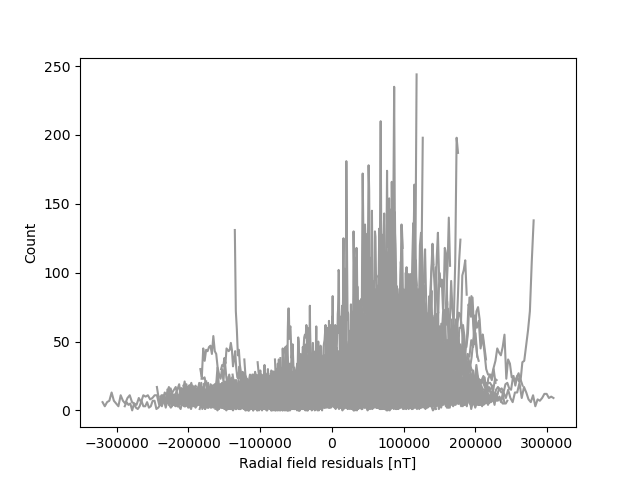

In [24]:
N_sim = 1000
core.target_var = np.max(C_Br_model)
#core.target_var = np.var(core.data)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = True, solve_cho = True)

In [25]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

<IPython.core.display.Javascript object>


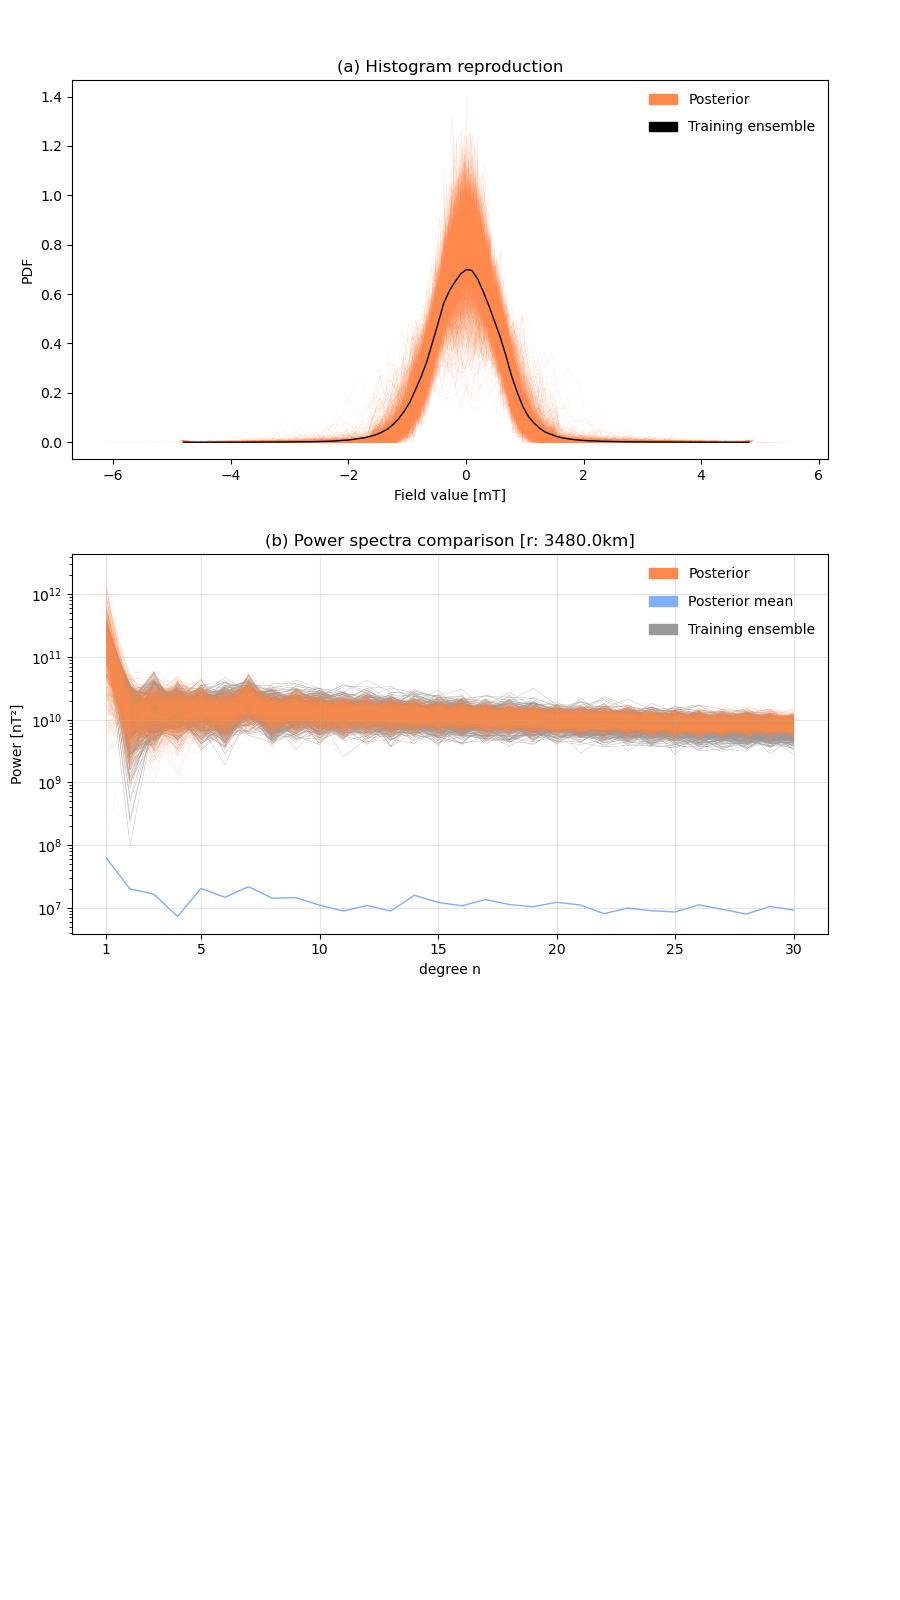

In [29]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, spec_lwidth = 0.05, label_fontsize = "medium",
                              res_use = False, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = True, hist_density = True,
                              hist_bins = 101, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "core_sh30_ens", save_dpi = 300)

In [27]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


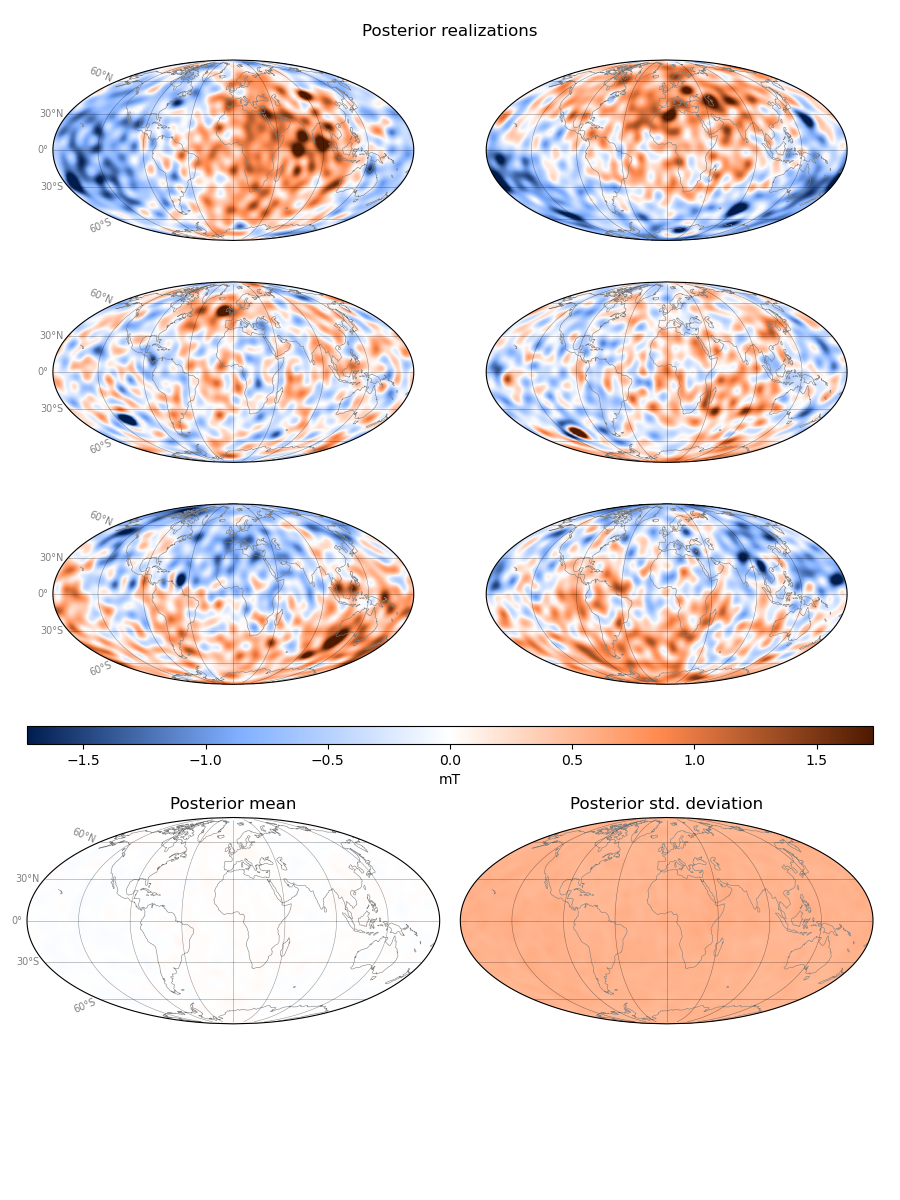

In [28]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = None, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_newTI", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
